In [ ]:
!pip install pandas
!pip install numpy==1.23

In [ ]:
!pip install tensorflow==2.12
!pip install pyarabic

In [ ]:
!pip install transformers

In [ ]:
!pip install ipywidgets
!pip install datasets
!pip install transformers[torch]
!pip install nvidia-ml-py3

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pyarabic.araby as araby
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)

2023-07-15 18:34:19.486294: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 18:34:19.514926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 18:34:19.945850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# cell-1  
#load and clean the data (removing diacritics and unwanted text)

df = pd.read_csv('poemsDataset.csv')
df.fillna('', inplace=True)
display(len(df))


def remove_diacritics(a):    
    return araby.strip_diacritics(a)

df['first_hemistich'] = df['first_hemistich'].apply(remove_diacritics)
df['second_hemistich'] = df['second_hemistich'].apply(remove_diacritics)

def normalizeBeforeTraining(df):
    df['first_hemistich'] = df['first_hemistich'].str.replace('النابغـة: ', '')
    df['second_hemistich'] = df['second_hemistich'].str.replace('الـربيع: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('عبيــد: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('امـرؤ القيسـ: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('امرؤ القيس: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(جلال الــــدين الــــرومي):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(لـوك الفيلسـوف الإنكليزي):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(كانت الفيلسوف الألماني ):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(بركســــــــــــــــون):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الحـــــــــــــــور):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الشــــــــــــــاعر):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الإنســـــــــــــــان):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('العلم):', '', regex=False)
    df['first_hemistich'] = df['first_hemistich'].str.replace('(العشــــــــــــــــق):', '', regex=False)
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الزهــــــــــــــــــرة):', '', regex=False)
    df['second_hemistich'] = df['second_hemistich'].str.replace('التوأم اليشكري: ', '', regex=False)  
    df['first_hemistich'] = df['first_hemistich'].str.replace('آ', 'أ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('آ', 'أ')
    df['first_hemistich'] = df['first_hemistich'].str.replace('[/":?،؟]', '')
    df['second_hemistich'] = df['second_hemistich'].str.replace('[/":?،؟]', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('  ', ' ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('  ', ' ')
    df['first_hemistich'] = df['first_hemistich'].str.replace('  ', ' ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('  ', ' ')


normalizeBeforeTraining(df)
df.drop(df[(df['first_hemistich'] == '') & (df['second_hemistich'] == '')].index, inplace=True)

#if first_hemistich == '', then copy the text from second_hemistich. then delete the text in the second_hemistich
df['first_hemistich'] = df.apply(lambda x: x['second_hemistich'] if x['first_hemistich'] == '' else x['first_hemistich'], axis=1)
df['second_hemistich'] = df.apply(lambda x: '' if x['first_hemistich'] == x['second_hemistich'] else x['second_hemistich'], axis=1)

df.reset_index(drop=True, inplace=True)

display(len(df))
# display(df[:10])
print('done')

2090907

2090907

done


In [4]:
# cell-2 
# preparing data for finetuning


df['second_hemistich'].replace('', 'E', inplace=True)
dfc = df[['first_hemistich', 'second_hemistich', 'meter', 'link']].copy()
dfc['text'] = dfc['first_hemistich'] + ' S ' + dfc['second_hemistich']

#removing verses without a meter
dfc = dfc[dfc['meter'] != ''] 
dfc = dfc[dfc['meter'] != 'unspecified']
dfc = dfc[dfc['meter'] != 'mixed']



classic = ['taweel', 'kamel', 'baseet', 'khafif', 'wafer', 'rajaz', 'ramel', 'mutaqarib',
           'saree', 'munsarih', 'mujtath', 'hazaj', 'madeed', 'mutadarak', 'muqtadab', 'mudari'] 

#including only verses with classical meters
# dfc = dfc[dfc['meter'].isin(classic)]

dfc.reset_index(drop=True, inplace=True)

dfc['meter'] = dfc['meter'].astype('category')
# display(dfc['meter'].unique())

dfc['label'] = dfc['meter'].cat.codes #assign cat_value for each meter type
dftrain, dftest = train_test_split(dfc, test_size=0.20, random_state=42, stratify=dfc['label'])
ytrain = to_categorical(dftrain['label']).astype('int32')
ytest = to_categorical(dftest['label']).astype('int32')

max_sequence_length = 32
train_batch_size = 256
classes_num = len(dfc['meter'].unique())

display(len(dfc))
display(len(dftrain))
display(len(dftest))

1911853

1529482

382371

In [5]:
#cell-3
#loading the tokenizer and the model

from transformers import AutoTokenizer,TFBertModel

tokenizer = AutoTokenizer.from_pretrained('faisalq/bert-base-arapoembert')
bert = TFBertModel.from_pretrained('faisalq/bert-base-arapoembert', from_pt=True)


2023-07-15 18:35:13.628164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-15 18:35:13.628910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-15 18:35:13.629065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
#cell-4
#tokenizing the data

xtrain = tokenizer(
    text=dftrain['text'].tolist(),
    add_special_tokens=True,
    max_length = max_sequence_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


xtest = tokenizer(
    text=dftest['text'].tolist(),
    add_special_tokens=True,
    max_length = max_sequence_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [7]:
# display(xtest)
display(xtest['input_ids'][0])

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    2,  2914,   277,   151,  2890,  1110,    83, 31553,  8365,
           9, 25033,   122,    85,  4147,  5444,   678,   321, 40125,
           3,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)>

In [7]:
#cell-5
# building classifier model

input_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_sequence_length,), dtype=tf.int32, name="attention_mask")

output = bert([input_ids, input_mask])[1] #pooled_output
output = tf.keras.layers.Dense(classes_num, activation='softmax', name='output')(output)
   
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)

optimizer = Adam(learning_rate=5e-05)


loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),

model.compile(optimizer = optimizer, loss = loss, metrics = metric)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109896960   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 32,                                            

In [8]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [9]:
#train the model (classic meters)

train_history = model.fit(
    x ={'input_ids':xtrain['input_ids'],'attention_mask':xtrain['attention_mask']}, y = ytrain,
    validation_data = ({'input_ids':xtest['input_ids'],'attention_mask':xtest['attention_mask']}, 
    ytest), epochs=2, batch_size=train_batch_size )


Epoch 1/2
5783/5783 [==============================] - 1549s 268ms/step - loss: 0.0640 - balanced_accuracy: 0.9858 - val_loss: 0.0496 - val_balanced_accuracy: 0.9893
Epoch 2/2
5783/5783 [==============================] - 1548s 268ms/step - loss: 0.0394 - balanced_accuracy: 0.9923 - val_loss: 0.0485 - val_balanced_accuracy: 0.9903


In [10]:
#model evaluation (classic meters)

pred = model.predict({'input_ids':xtest['input_ids'],'attention_mask':xtest['attention_mask']})

y_pred = np.argmax(pred, axis = 1)
y_pred = to_categorical(y_pred, num_classes=classes_num).astype('int32')

print(classification_report(ytest, y_pred, digits=4))

11565/11565 [==============================] - 518s 45ms/step
              precision    recall  f1-score   support

           0     0.9961    0.9950    0.9955     53009
           1     0.9112    0.8112    0.8583      1833
           2     0.9906    0.9937    0.9921     81382
           3     0.9942    0.9935    0.9938     34821
           4     0.9742    0.9048    0.9383      1755
           5     0.7143    0.2778    0.4000        72
           6     0.9653    0.9775    0.9714      3871
           7     0.9737    0.9787    0.9762      5973
           8     0.8914    0.8211    0.8548       190
           9     0.9524    0.9359    0.9441      1326
          10     0.9916    0.9919    0.9918     13905
          11     0.9709    0.9709    0.9709     22267
          12     0.9857    0.9857    0.9857     17971
          13     0.9839    0.9782    0.9811     12252
          14     0.9972    0.9977    0.9975     88553
          15     0.9876    0.9935    0.9905     30891

   micro avg     0

In [9]:
#train the model (all meters)

train_history = model.fit(
    x ={'input_ids':xtrain['input_ids'],'attention_mask':xtrain['attention_mask']}, y = ytrain,
    validation_data = ({'input_ids':xtest['input_ids'],'attention_mask':xtest['attention_mask']}, 
    ytest), epochs=2, batch_size=train_batch_size )


Epoch 1/2
5975/5975 [==============================] - 1646s 275ms/step - loss: 0.1174 - balanced_accuracy: 0.9712 - val_loss: 0.0915 - val_balanced_accuracy: 0.9772
Epoch 2/2
5975/5975 [==============================] - 1652s 277ms/step - loss: 0.0818 - balanced_accuracy: 0.9798 - val_loss: 0.0923 - val_balanced_accuracy: 0.9782


In [10]:
#model evaluation (all meters)

pred = model.predict({'input_ids':xtest['input_ids'],'attention_mask':xtest['attention_mask']})

y_pred = np.argmax(pred, axis = 1)
y_pred = to_categorical(y_pred, num_classes=classes_num).astype('int32')

print(classification_report(ytest, y_pred, digits=4))

11950/11950 [==============================] - 541s 45ms/step
              precision    recall  f1-score   support

           0     0.9933    0.9916    0.9925     53009
           1     0.7773    0.6392    0.7015      1480
           2     0.9448    0.9336    0.9392       587
           3     0.8570    0.8422    0.8495      1686
           4     0.0000    0.0000    0.0000        10
           5     0.8813    0.8347    0.8574      1833
           6     0.9863    0.9937    0.9900     81382
           7     0.0000    0.0000    0.0000        12
           8     0.9908    0.9909    0.9908     34821
           9     0.0000    0.0000    0.0000         1
          10     0.9398    0.9066    0.9229      1755
          11     0.8558    0.3463    0.4931       257
          12     0.6980    0.5517    0.6163       377
          13     0.7505    0.7024    0.7257      7682
          14     0.8750    0.1944    0.3182        72
          15     0.9513    0.9432    0.9472      3871
          16     0.

In [11]:
#finetuned classifier models can be downloaded from:
# https://huggingface.co/faisalq/arapoembert-all-meters-classifier/blob/main/all_meters_classifierTF_10L12H.h5
# https://huggingface.co/faisalq/arapoembert-classic-meter-classifier/blob/main/classic_meters_classifierTF_10L12H.h5

# classifier_path = 'finetuned/classic_meters_classifierTF_10L12H.h5'
classifier_path = 'finetuned/all_meters_classifierTF_10L12H.h5'



In [12]:
#saving finetuned model locally

model.save_weights(classifier_path)

In [26]:
#loading the finetuned model locally
# it's necessary to create new model similar to the saved one, then load it

from transformers import TFBertModel

def create_model():
    input_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(max_sequence_length,), dtype=tf.int32, name="attention_mask")
    bert = TFBertModel.from_pretrained('faisalq/bert-base-arapoembert', from_pt=True)
    
    output = bert([input_ids, input_mask])[1] #pooled_output
    output = tf.keras.layers.Dense(classes_num, activation='softmax', name='output')(output)
    
    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)
    
    optimizer = Adam(learning_rate=5e-05)
     
    loss =CategoricalCrossentropy(from_logits = True)
    metric = CategoricalAccuracy('balanced_accuracy'),
    
    model.compile(optimizer = optimizer, loss = loss, metrics = metric)
    
    return model

model = create_model()
model.load_weights(classifier_path)

In [ ]:
#model evaluation

pred = model.predict({'input_ids':xtest['input_ids'],'attention_mask':xtest['attention_mask']})

y_pred = np.argmax(pred, axis = 1)
y_pred = to_categorical(y_pred, num_classes=classes_num).astype('int32')

print(classification_report(ytest, y_pred, digits=4))

In [ ]:

# further finetuning the model

train_history = model.fit(
    x ={'input_ids':xtrain['input_ids'],'attention_mask':xtrain['attention_mask']}, y = ytrain,
    validation_data = ({'input_ids':xtest['input_ids'],'attention_mask':xtest['attention_mask']}, 
    ytest), epochs=3, batch_size=train_batch_size )


In [ ]:
#rearrangeing meters' labels for a neat confusion matrix and classification report
#all-meters


In [55]:

dfc['m'] = dfc['meter'].astype(str) + ' ' + dfc['label'].astype(str)

df2 = dfc.groupby(['m'])['m'].count().sort_values(ascending=False)
meters = ['Taweel', 'Kamel', 'Baseet', 'Khafif', 'Wafer', 'Rajaz', 'Ramel', 'Mutaqarib',
    'Saree', 'Munsarih', 'Mujtath', 'Hazaj', 'Madeed', 'Mutadarak', 'Muqtadab', 'Mudari',
    'Muashah', 'Free_form', 'Colloquial', 'Doubeet', 'Mawalia', 'Masehube', 'Selselah', 'Zajal',
    'Kankan', 'Hajini', 'Sakhri', 'Luaihani']
ids = [25, 6, 0, 8, 26, 20, 21, 19,
    23, 16, 15, 5, 10, 18, 17, 14,
    13, 3, 1, 2, 12, 11, 24, 27,
    7, 4, 22, 9]
display(df2)

m
taweel 25       442763
kamel 6         406908
baseet 0        265045
khafif 8        174105
wafer 26        154455
rajaz 20        111333
ramel 21         89857
mutaqarib 19     69523
saree 23         61261
muashah 13       38409
munsarih 16      29863
mujtath 15       19357
hazaj 5           9166
madeed 10         8775
free_form 3       8431
colloquial 1      7399
mutadarak 18      6631
doubeet 2         2937
mawalia 12        1887
masehube 11       1283
muqtadab 17        949
selselah 24        945
mudari 14          360
zajal 27            81
kankan 7            59
hajini 4            48
sakhri 22           16
luaihani 9           7
Name: m, dtype: int64

In [ ]:

from sklearn.metrics import confusion_matrix

y_pred2 = np.argmax(pred, axis = 1)
ytest2 = np.argmax(ytest, axis = 1)

#done manually
ids = [25, 6, 0, 8, 26, 20, 21, 19,
    23, 16, 15, 5, 10, 18, 17, 14,
    13, 3, 1, 2, 12, 11, 24, 27,
    7, 4, 22, 9]
ids2 = {k: v for v, k in enumerate(ids)}
# display(ids2[0])
for i in range(len(y_pred2)):
    ytest2[i] = ids2[ytest2[i]]
    y_pred2[i] = ids2[y_pred2[i]]

matrix = confusion_matrix(ytest2, y_pred2)
# matrix

In [79]:
print(classification_report(ytest2, y_pred2, digits=4))

              precision    recall  f1-score   support

           0     0.9963    0.9971    0.9967     88553
           1     0.9863    0.9937    0.9900     81382
           2     0.9933    0.9916    0.9925     53009
           3     0.9908    0.9909    0.9908     34821
           4     0.9860    0.9913    0.9886     30891
           5     0.9580    0.9620    0.9600     22267
           6     0.9384    0.9725    0.9552     17971
           7     0.9863    0.9900    0.9882     13905
           8     0.9793    0.9710    0.9752     12252
           9     0.9820    0.9690    0.9755      5973
          10     0.9513    0.9432    0.9472      3871
          11     0.8813    0.8347    0.8574      1833
          12     0.9398    0.9066    0.9229      1755
          13     0.8916    0.9057    0.8986      1326
          14     0.9000    0.8526    0.8757       190
          15     0.8750    0.1944    0.3182        72
          16     0.7505    0.7024    0.7257      7682
          17     0.8570    

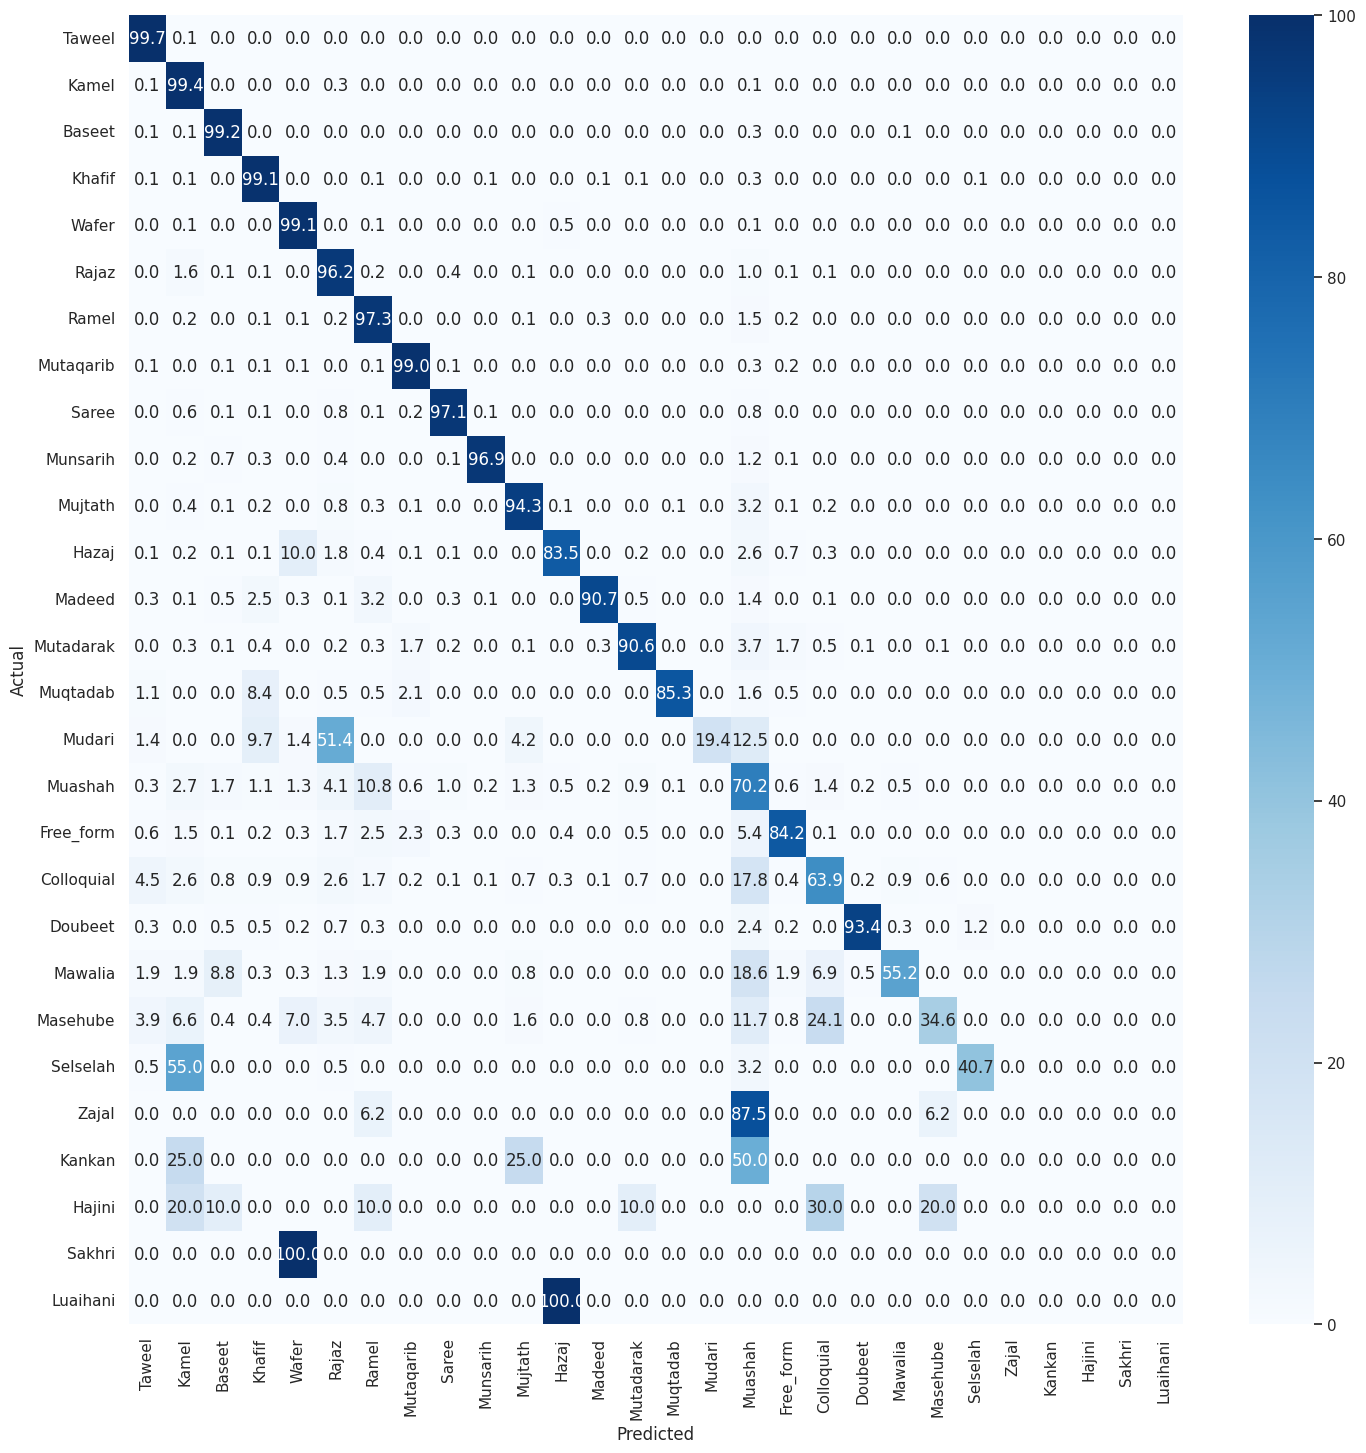

In [88]:
import seaborn as sn, numpy as np
import matplotlib.pyplot as plt

meters = ['Taweel', 'Kamel', 'Baseet', 'Khafif', 'Wafer', 'Rajaz', 'Ramel', 'Mutaqarib',
    'Saree', 'Munsarih', 'Mujtath', 'Hazaj', 'Madeed', 'Mutadarak', 'Muqtadab', 'Mudari',
    'Muashah', 'Free_form', 'Colloquial', 'Doubeet', 'Mawalia', 'Masehube', 'Selselah', 'Zajal',
    'Kankan', 'Hajini', 'Sakhri', 'Luaihani']

matrix = confusion_matrix(ytest2, y_pred2)
cmn = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
cmn = cmn*100
fig, ax = plt.subplots(figsize=(17,17))
sn.set(font_scale=1)
sn.heatmap(cmn, annot=True, fmt='.1f', xticklabels=meters, yticklabels=meters, cmap="Blues",
          annot_kws={"size": 12})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('all_meters_cm.png')
plt.show(block=False)

In [ ]:
#rearrangeing meters' labels for a neat confusion matrix and classification report
#classic-meters


In [13]:

dfc['m'] = dfc['meter'].astype(str) + ' ' + dfc['label'].astype(str)

df2 = dfc.groupby(['m'])['m'].count().sort_values(ascending=False)
meters = ['Taweel', 'Kamel', 'Baseet', 'Khafif', 'Wafer', 'Rajaz', 'Ramel', 'Mutaqarib',
    'Saree', 'Munsarih', 'Mujtath', 'Hazaj', 'Madeed', 'Mutadarak', 'Muqtadab', 'Mudari']
ids = [14, 2, 0, 3, 15, 11, 12, 10,
    13, 7, 6, 1, 4, 9, 8, 5]
display(df2)

m
taweel 14       442763
kamel 2         406908
baseet 0        265045
khafif 3        174105
wafer 15        154455
rajaz 11        111333
ramel 12         89857
mutaqarib 10     69523
saree 13         61261
munsarih 7       29863
mujtath 6        19357
hazaj 1           9166
madeed 4          8775
mutadarak 9       6631
muqtadab 8         949
mudari 5           360
Name: m, dtype: int64

In [ ]:

from sklearn.metrics import confusion_matrix

y_pred2 = np.argmax(pred, axis = 1)
ytest2 = np.argmax(ytest, axis = 1)

#done manually
meters = ['Taweel', 'Kamel', 'Baseet', 'Khafif', 'Wafer', 'Rajaz', 'Ramel', 'Mutaqarib',
    'Saree', 'Munsarih', 'Mujtath', 'Hazaj', 'Madeed', 'Mutadarak', 'Muqtadab', 'Mudari']
ids = [14, 2, 0, 3, 15, 11, 12, 10,
    13, 7, 6, 1, 4, 9, 8, 5]

ids2 = {k: v for v, k in enumerate(ids)}
# display(ids2[0])
for i in range(len(y_pred2)):
    ytest2[i] = ids2[ytest2[i]]
    y_pred2[i] = ids2[y_pred2[i]]

matrix = confusion_matrix(ytest2, y_pred2)
# matrix

In [15]:
print(classification_report(ytest2, y_pred2, digits=4))

              precision    recall  f1-score   support

           0     0.9972    0.9977    0.9975     88553
           1     0.9906    0.9937    0.9921     81382
           2     0.9961    0.9950    0.9955     53009
           3     0.9942    0.9935    0.9938     34821
           4     0.9876    0.9935    0.9905     30891
           5     0.9709    0.9709    0.9709     22267
           6     0.9857    0.9857    0.9857     17971
           7     0.9916    0.9919    0.9918     13905
           8     0.9839    0.9782    0.9811     12252
           9     0.9737    0.9787    0.9762      5973
          10     0.9653    0.9775    0.9714      3871
          11     0.9112    0.8112    0.8583      1833
          12     0.9742    0.9048    0.9383      1755
          13     0.9524    0.9359    0.9441      1326
          14     0.8914    0.8211    0.8548       190
          15     0.7143    0.2778    0.4000        72

    accuracy                         0.9903    370071
   macro avg     0.9550   

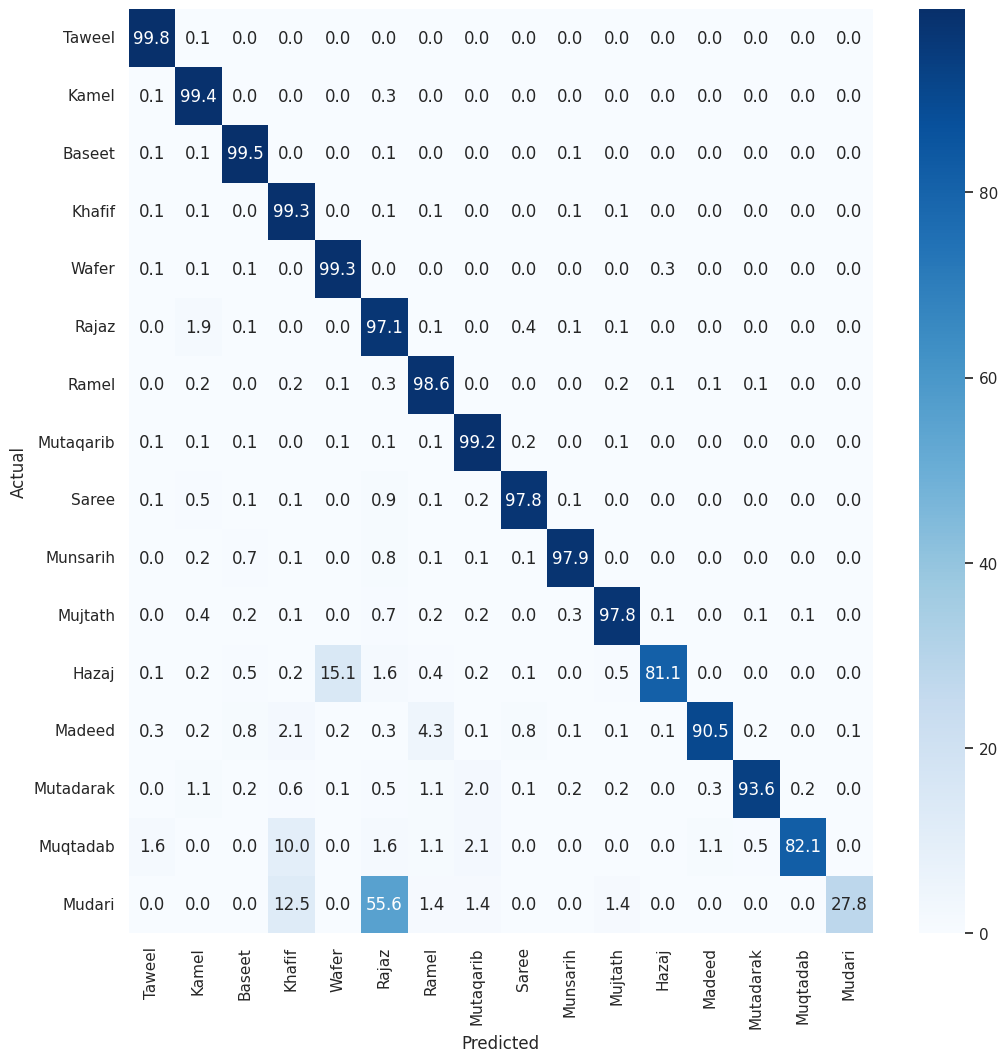

In [23]:
import seaborn as sn, numpy as np
import matplotlib.pyplot as plt

meters = ['Taweel', 'Kamel', 'Baseet', 'Khafif', 'Wafer', 'Rajaz', 'Ramel', 'Mutaqarib',
    'Saree', 'Munsarih', 'Mujtath', 'Hazaj', 'Madeed', 'Mutadarak', 'Muqtadab', 'Mudari']

matrix = confusion_matrix(ytest2, y_pred2)
cmn = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
cmn = cmn*100
fig, ax = plt.subplots(figsize=(12,12))
sn.set(font_scale=1)
sn.heatmap(cmn, annot=True, fmt='.1f', xticklabels=meters, yticklabels=meters, cmap="Blues",
          annot_kws={"size": 12})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('classic_meters_cm.png')
plt.show(block=False)